## Importing Required Packages

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import glob 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import random
import cv2
import sys

## Reading the Data/Images

In [2]:
tumor = []
path = './data/brain_tumor_dataset/yes/*.jpg'
for f in glob.iglob(path):
    img = cv2.imread(f)
    img = cv2.resize(img, (128, 128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g ,b])
    tumor.append(img)

healthy = []
path = './data/brain_tumor_dataset/no/*.jpg'
for f in glob.iglob(path):
    img = cv2.imread(f)
    img = cv2.resize(img, (128, 128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g ,b])
    healthy.append(img)

In [3]:
print("No tumor : " ,len(healthy))
print("Have Tumor :", len(tumor))

No tumor :  91
Have Tumor : 154


In [4]:
healthy = np.array(healthy)
tumor = np.array(tumor)

In [5]:
tumor.shape

(154, 128, 128, 3)

In [6]:
healthy.shape

(91, 128, 128, 3)

In [7]:
All = np.concatenate((healthy, tumor))
All.shape

(245, 128, 128, 3)

In [8]:
np.random.choice(10, 5, replace = False) # Replace makes sure the numbers are not repeated (test)

array([0, 9, 1, 5, 4])

## Visualizing the MRI Images

In [9]:
def plot_random(healthy, tumor, num=5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]
    
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('healthy')
        plt.imshow(healthy_imgs[i])
        
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('tumor')
        plt.imshow(tumor_imgs[i])

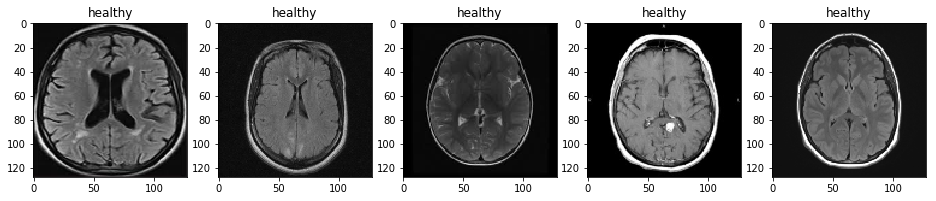

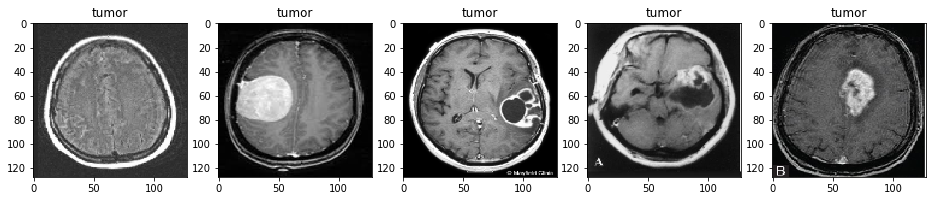

In [10]:
plot_random(healthy, tumor, num=5)

## Creating Torch Dataset Class

In [11]:
class Dataset(object):

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

## Creating MRI Custom Dataset

In [12]:
class MRI(Dataset):
    def __init__(self):
        
        tumor = []
        healthy = []
        
        for f in glob.iglob("./data/brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            tumor.append(img)

        for f in glob.iglob("./data/brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)
        
        # labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)
        
        # concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))
        
    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, index):
        
        sample = {'image': self.images[index], 'label':self.labels[index]}
        
        return sample
    
    def normalize(self):
        self.images = self.images/255.0

In [13]:
mri_dataset = MRI()
mri_dataset.normalize()

## Dataloader

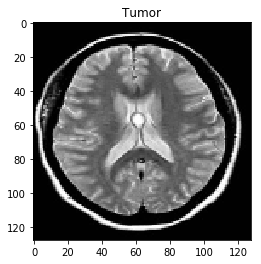

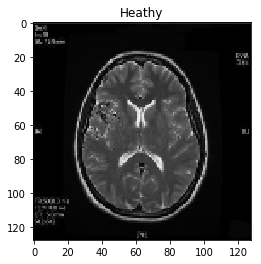

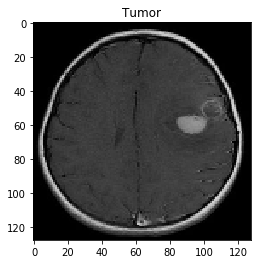

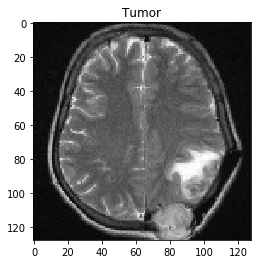

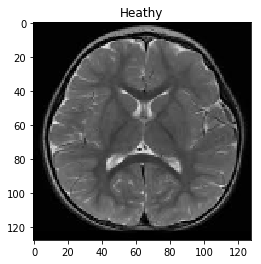

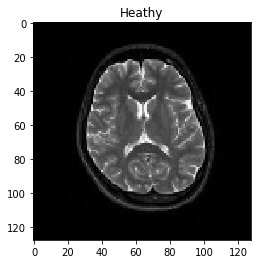

In [14]:
names={0:'Heathy', 1:'Tumor'}
dataloader = DataLoader(mri_dataset, shuffle=True)
for i, sample in enumerate(dataloader):
    img = sample['image'].squeeze()
    img = img.reshape((img.shape[1], img.shape[2], img.shape[0]))
    plt.title(names[sample['label'].item()])
    plt.imshow(img)
    plt.show()
    if i == 5:
        break

## Evaluating the Newborn - NN (Pre-Training)

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5))
        
        self.fc_model = nn.Sequential(
        nn.Linear(in_features=256, out_features=120),
        nn.Tanh(),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=1))
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)
        
        return x
            

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


cpu_tensor = torch.rand(10).to(device)

gpu_tensor = cpu_tensor.to(device)

print(cpu_tensor, cpu_tensor.dtype, type(cpu_tensor), cpu_tensor.type())
print(gpu_tensor, gpu_tensor.dtype, type(gpu_tensor), gpu_tensor.type())

print(cpu_tensor*gpu_tensor)

tensor([0.9029, 0.2549, 0.6183, 0.6454, 0.7467, 0.3951, 0.8155, 0.0386, 0.6608,
        0.8503]) torch.float32 <class 'torch.Tensor'> torch.FloatTensor
tensor([0.9029, 0.2549, 0.6183, 0.6454, 0.7467, 0.3951, 0.8155, 0.0386, 0.6608,
        0.8503]) torch.float32 <class 'torch.Tensor'> torch.FloatTensor
tensor([0.8151, 0.0650, 0.3823, 0.4166, 0.5576, 0.1561, 0.6650, 0.0015, 0.4366,
        0.7230])


In [17]:
mri_dataset = MRI()
mri_dataset.normalize()  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

In [18]:
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [19]:
model.eval()
outputs = []
y_true = []
with torch.no_grad():
    for D in dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())

C:\Users\ROG\.conda\envs\MRI\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [20]:
outputs = np.concatenate( outputs, axis=0 ).squeeze()
y_true = np.concatenate( y_true, axis=0 ).squeeze()

In [21]:
def threshold(scores,threshold=0.50, minimum=0, maximum = 1.0):
    x = np.array(list(scores))
    x[x >= threshold] = maximum
    x[x < threshold] = minimum
    return x

In [22]:
accuracy_score(y_true, threshold(outputs))

0.49387755102040815

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

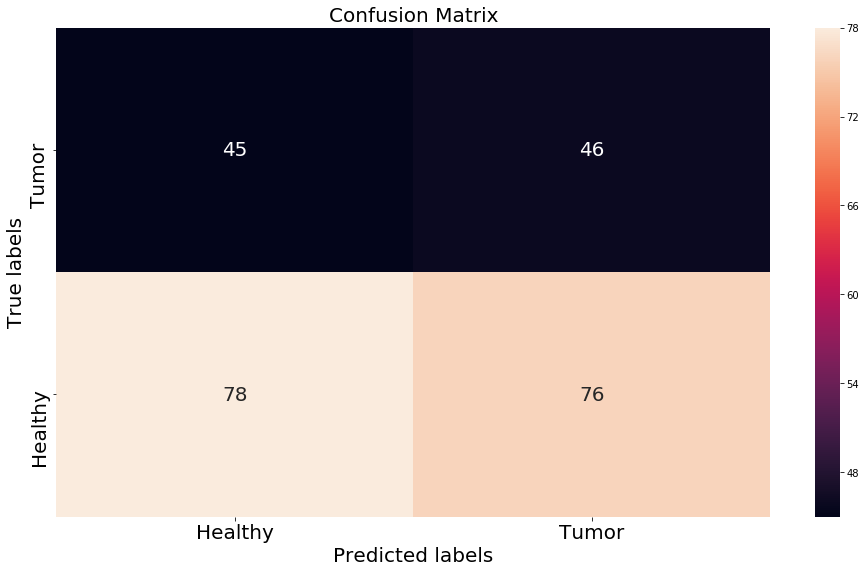

In [23]:
plt.figure(figsize=(16,9))
cm = confusion_matrix(y_true, threshold(outputs))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})

ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20) 
ax.set_title('Confusion Matrix', fontsize=20)
ax.xaxis.set_ticklabels(['Healthy','Tumor'], fontsize=20)
ax.yaxis.set_ticklabels(['Tumor','Healthy'], fontsize=20)

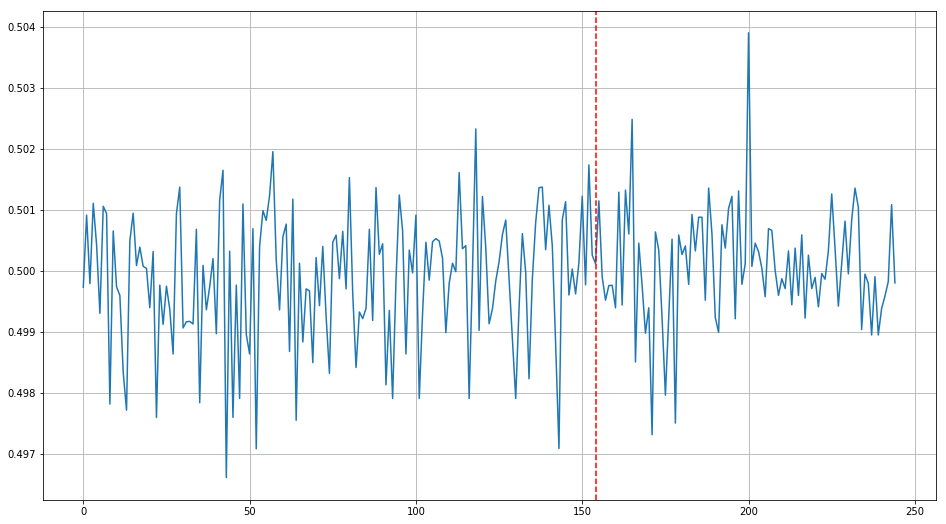

In [24]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

## Training the model

In [25]:
eta = 0.0001
EPOCH = 400
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
model.train()

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [31]:
for epoch in range(1, EPOCH):
    losses = []
    for D in dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)
        
        error = nn.BCELoss() 
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tLoss: {:.6f}'.format(epoch+1, np.mean(losses)))

Train Epoch: 10	Loss: 0.017944
Train Epoch: 20	Loss: 0.014002
Train Epoch: 30	Loss: 0.011366
Train Epoch: 40	Loss: 0.009472
Train Epoch: 50	Loss: 0.008043
Train Epoch: 60	Loss: 0.006927
Train Epoch: 70	Loss: 0.006034
Train Epoch: 80	Loss: 0.005304
Train Epoch: 90	Loss: 0.004698
Train Epoch: 100	Loss: 0.004188
Train Epoch: 110	Loss: 0.003755
Train Epoch: 120	Loss: 0.003383
Train Epoch: 130	Loss: 0.003060
Train Epoch: 140	Loss: 0.002779
Train Epoch: 150	Loss: 0.002533
Train Epoch: 160	Loss: 0.002315
Train Epoch: 170	Loss: 0.002122
Train Epoch: 180	Loss: 0.001949
Train Epoch: 190	Loss: 0.001795
Train Epoch: 200	Loss: 0.001657
Train Epoch: 210	Loss: 0.001532
Train Epoch: 220	Loss: 0.001419
Train Epoch: 230	Loss: 0.001317
Train Epoch: 240	Loss: 0.001224
Train Epoch: 250	Loss: 0.001139
Train Epoch: 260	Loss: 0.001061
Train Epoch: 270	Loss: 0.000990
Train Epoch: 280	Loss: 0.000925
Train Epoch: 290	Loss: 0.000865
Train Epoch: 300	Loss: 0.000809
Train Epoch: 310	Loss: 0.000758
Train Epoch: 320	

## Results Post-Training Procedure

In [32]:
model.eval()
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)
outputs=[]
y_true = []
with torch.no_grad():
    for D in dataloader:
        image =  D['image'].to(device)
        label = D['label'].to(device)
        
        y_hat = model(image)
        
        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
        
outputs = np.concatenate( outputs, axis=0 )
y_true = np.concatenate( y_true, axis=0 )

In [33]:
accuracy_score(y_true, threshold(outputs))

1.0

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

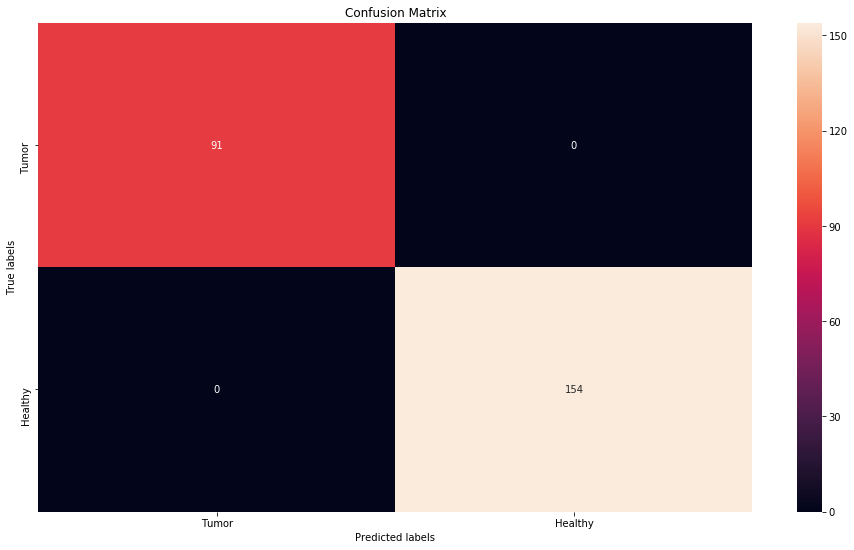

In [35]:
cm = confusion_matrix(y_true, threshold(outputs))
plt.figure(figsize=(16,9))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Tumor','Healthy'])
ax.yaxis.set_ticklabels(['Tumor','Healthy'])

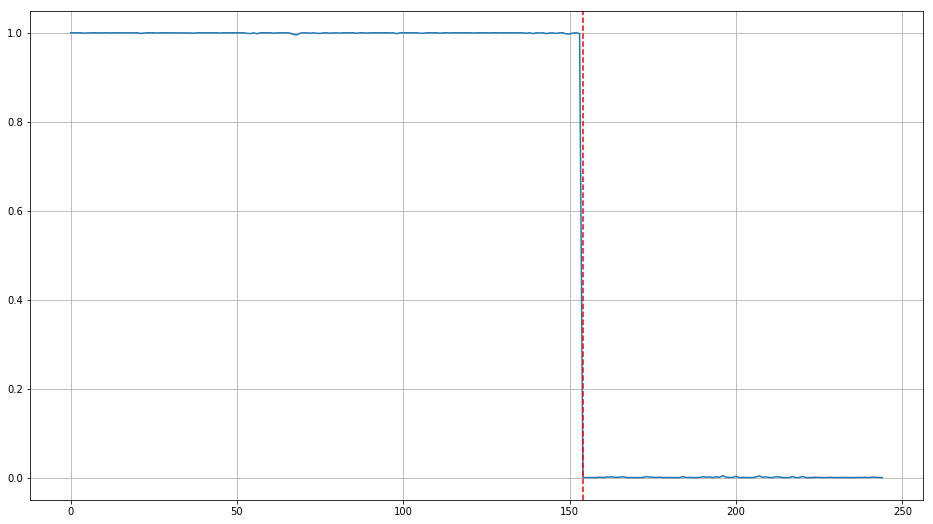

In [36]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

## Visualising the feature maps of the Convolution Layers

In [37]:
model

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [38]:
no_of_layers = 0
conv_layers = []

In [39]:
model_children = list(model.children())
model_children

[Sequential(
   (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
   (1): Tanh()
   (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
   (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
   (4): Tanh()
   (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
 ), Sequential(
   (0): Linear(in_features=256, out_features=120, bias=True)
   (1): Tanh()
   (2): Linear(in_features=120, out_features=84, bias=True)
   (3): Tanh()
   (4): Linear(in_features=84, out_features=1, bias=True)
 )]

In [40]:
for child in model_children:
    if type(child) == nn.Sequential:
        for layer in child.children():
            if type(layer) == nn.Conv2d:
                no_of_layers += 1
                conv_layers.append(layer)

In [41]:
conv_layers

[Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1)),
 Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))]

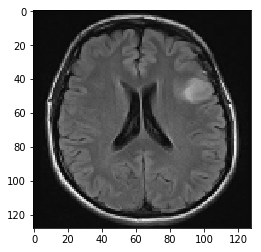

In [55]:
img = mri_dataset[108]['image']
plt.imshow(img.reshape(128,128,3))

In [56]:
img = torch.from_numpy(img).to(device)

In [57]:
img.shape

torch.Size([3, 128, 128])

In [58]:
img = img.unsqueeze(0)
img.shape

torch.Size([1, 3, 128, 128])

In [59]:
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

Layer  1


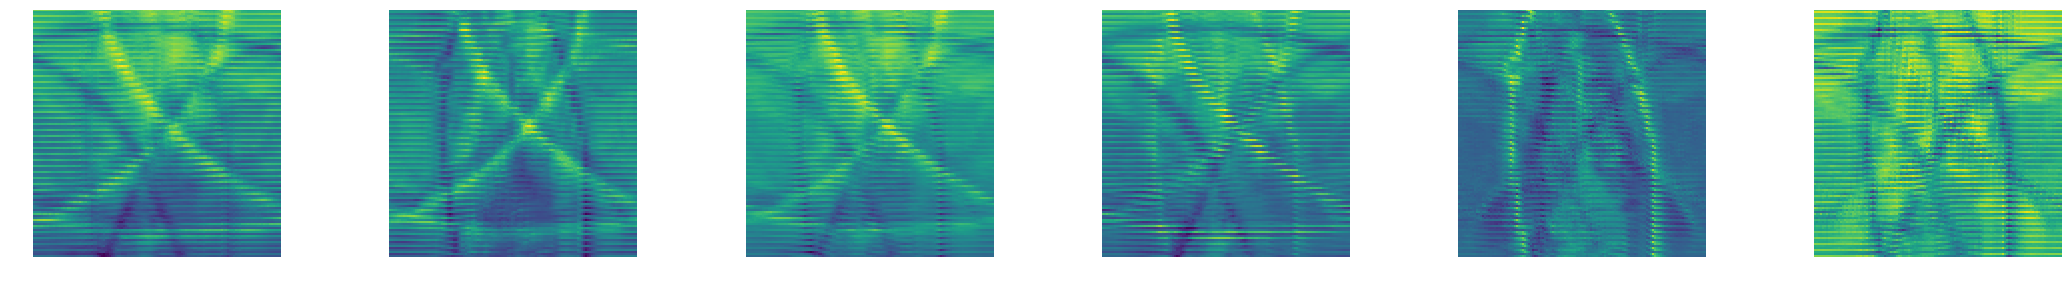

Layer  2


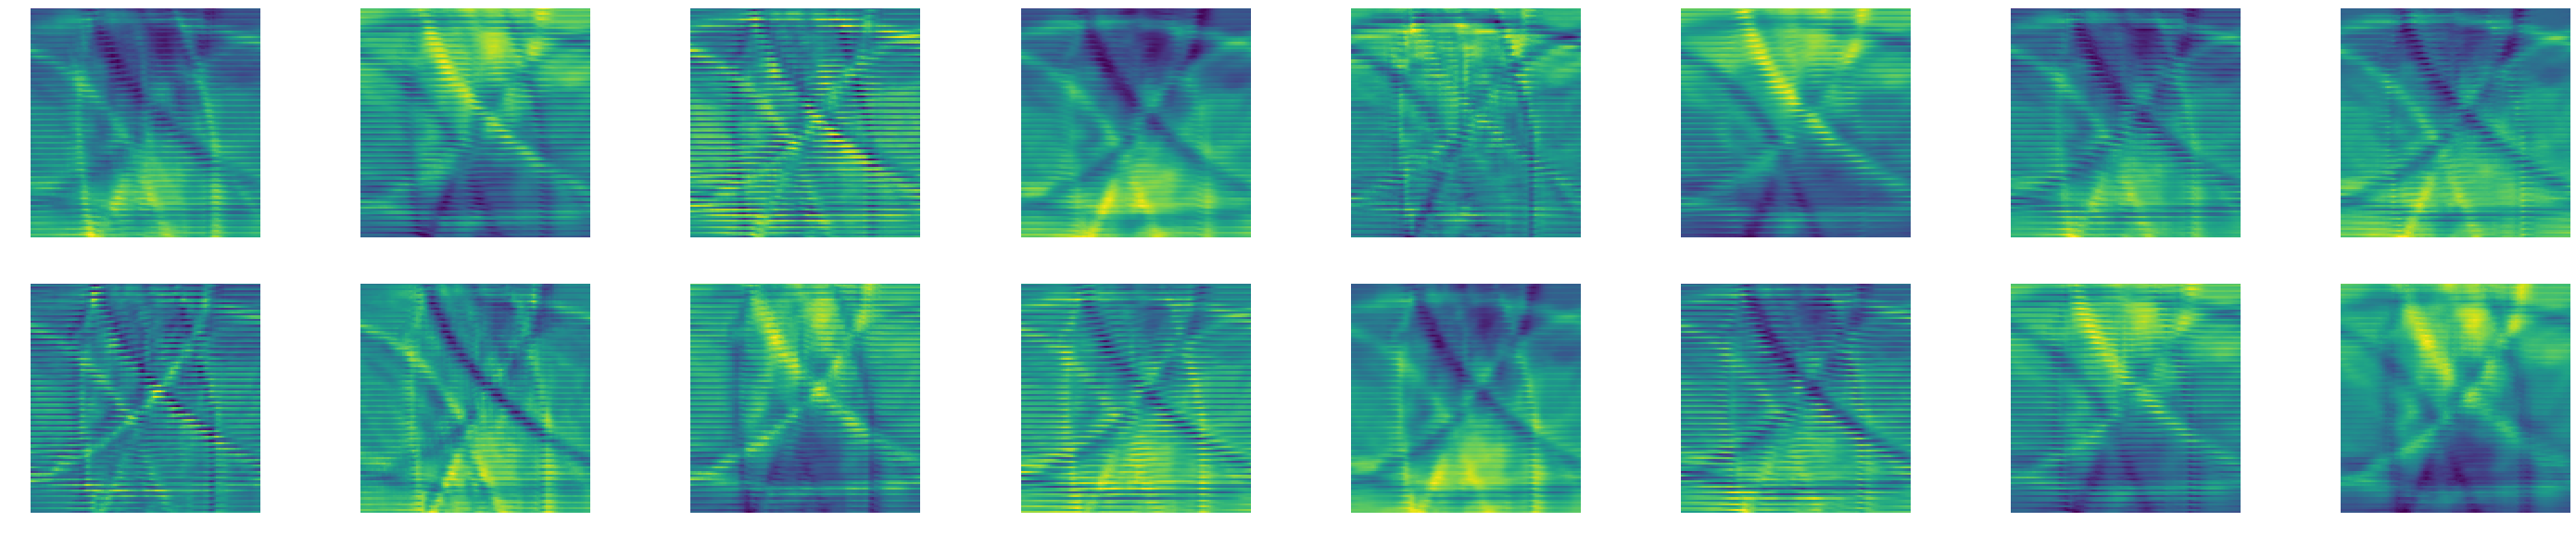

In [60]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(50, 10))
    layer_viz = outputs[num_layer].squeeze()
    print("Layer ",num_layer+1)
    for i, f in enumerate(layer_viz):
        plt.subplot(2, 8, i + 1)
        plt.imshow(f.detach().cpu().numpy())
        plt.axis("off")
    plt.show()
    plt.close()

## Preparing Validation Set

In [61]:
from sklearn.model_selection import train_test_split

In [62]:
class MRI(Dataset):
    
    def __init__(self):
        
        self.X_train, self.y_train, self.X_val, self.y_val = None, None, None, None
        

        self.mode = 'train'
        
        tumor = []
        healthy = []
        
        for f in glob.iglob("./data/brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            tumor.append(img)

        for f in glob.iglob("./data/brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)
        
        # labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)
        
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))
    
    
    def train_val_split(self):
        self.X_train, self.X_val, self.y_train, self.y_val = \
        train_test_split(self.images, self.labels, test_size=0.20, random_state=42)
        
    def __len__(self):
        if self.mode == 'train':
            return self.X_train.shape[0]
        elif self.mode == 'val':
            return self.X_val.shape[0]
    
    def __getitem__(self, idx):
        if self.mode== 'train':
            sample = {'image': self.X_train[idx], 'label': self.y_train[idx]}
        
        elif self.mode== 'val':
            sample = {'image': self.X_val[idx], 'label': self.y_val[idx]}
        
        return sample
    
    def normalize(self):
        self.images = self.images/255.0

## Checking for Overfitting 

In [64]:
mri_dataset = MRI()
mri_dataset.normalize()
mri_dataset.train_val_split()

In [65]:
train_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [67]:
device = torch.device("cpu")
model = CNN().to(device)

In [68]:
eta=0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=eta)

In [69]:
epoch_train_loss = []
epoch_val_loss = []

In [70]:
for epoch in range(1,600):
    train_losses = []
    
    model.train()
    mri_dataset.mode = 'train'
    for D in train_dataloader:
        
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        
        y_hat = model(data)
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    epoch_train_loss.append(np.mean(train_losses))
    

    val_losses = []
    model.eval()
    
    mri_dataset.mode = 'val'
    
    with torch.no_grad():
        for D in val_dataloader:            
            data = D['image'].to(device)
            label = D['label'].to(device)
            y_hat = model(data)
            error = nn.BCELoss()
            loss = torch.sum(error(y_hat.squeeze(), label))
            val_losses.append(loss.item())
    
    epoch_val_loss.append(np.mean(val_losses))
    
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tTrain Loss: {:.6f}\tVal Loss: {:.6f}'.format(epoch+1, np.mean(train_losses),np.mean(val_losses)))
    

Train Epoch: 10	Train Loss: 0.622301	Val Loss: 0.588267
Train Epoch: 20	Train Loss: 0.607414	Val Loss: 0.585219
Train Epoch: 30	Train Loss: 0.573563	Val Loss: 0.564152
Train Epoch: 40	Train Loss: 0.545526	Val Loss: 0.551937
Train Epoch: 50	Train Loss: 0.505465	Val Loss: 0.567302
Train Epoch: 60	Train Loss: 0.485412	Val Loss: 0.585012
Train Epoch: 70	Train Loss: 0.474173	Val Loss: 0.601278
Train Epoch: 80	Train Loss: 0.459519	Val Loss: 0.608140
Train Epoch: 90	Train Loss: 0.423168	Val Loss: 0.614107
Train Epoch: 100	Train Loss: 0.434795	Val Loss: 0.613427
Train Epoch: 110	Train Loss: 0.395575	Val Loss: 0.637489
Train Epoch: 120	Train Loss: 0.366108	Val Loss: 0.645091
Train Epoch: 130	Train Loss: 0.370526	Val Loss: 0.637183
Train Epoch: 140	Train Loss: 0.348789	Val Loss: 0.651140
Train Epoch: 150	Train Loss: 0.358757	Val Loss: 0.660061
Train Epoch: 160	Train Loss: 0.320987	Val Loss: 0.655492
Train Epoch: 170	Train Loss: 0.318856	Val Loss: 0.662246
Train Epoch: 180	Train Loss: 0.364888	Va

Text(0, 0.5, 'Loss')

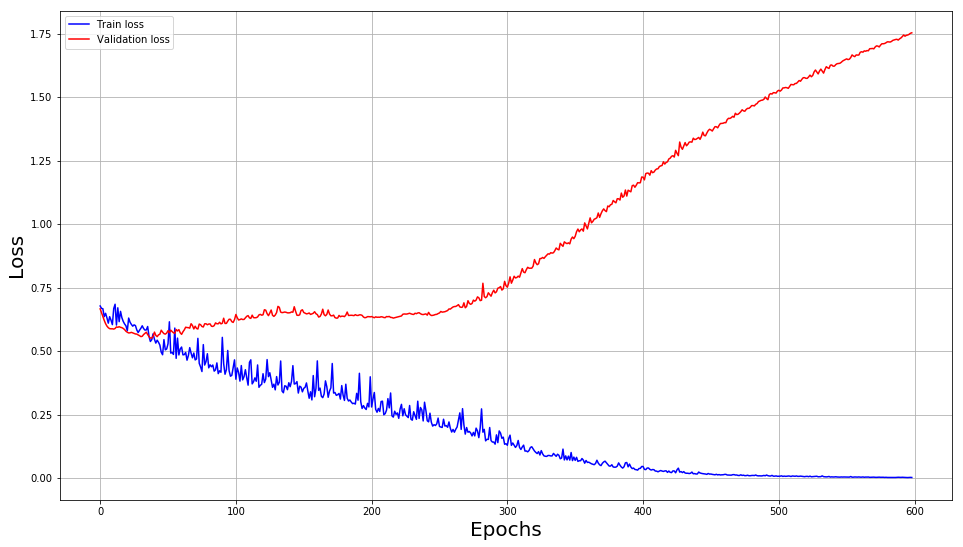

In [71]:
plt.figure(figsize=(16,9))
plt.plot(epoch_train_loss, c='b', label='Train loss')
plt.plot(epoch_val_loss, c='r', label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)